## **Exericse: Time Series (ARIMA)**

**Gunakan dataset AAPL.csv**

Prediksi harga saham Apple (variable:close) untuk 3 bulan ke depan.

1. Lakukan EDA.
1. Train Test Split: dengan test set Oct-Dec 2022 
1. Cek apakah data sudah stasioner? Jika belum, lakukan differencing.
1. Gunakan ADF test untuk mengecek stasionerity data secara statistik.
1. Cari model ARIMA terbaik melalui grafik ACF & PACF.
1. Buat modelnya dan lakukan forecasting untuk periode 1 tahun.

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [3]:
# Close tiap bulan dari Jan 2001 sampai Dec 2003
df = pd.read_csv('AAPL.csv')
display(df.head(), df.tail())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.347939,135480400
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.634842,146322800
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.213631,118387200
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.869308,108872000
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,74.041489,132079200


,Date,Open,High,Low,Close,Adj Close,Volume
751,2022-12-23,130.919998,132.419998,129.639999,131.860001,131.477127,63814900
752,2022-12-27,131.380005,131.410004,128.720001,130.029999,129.652435,69007800
753,2022-12-28,129.669998,131.029999,125.870003,126.040001,125.674026,85438400
754,2022-12-29,127.989998,130.479996,127.730003,129.610001,129.233658,75703700
755,2022-12-30,128.410004,129.949997,127.430000,129.929993,129.552719,77034200


In [4]:
# hanya pakai 'Date', 'Close'

df = df.copy()[['Date', 'Close']]
display(df.head(), df.tail())

,Date,Close
0,2020-01-02,75.087502
1,2020-01-03,74.357498
2,2020-01-06,74.949997
3,2020-01-07,74.597504
4,2020-01-08,75.797501


,Date,Close
751,2022-12-23,131.860001
752,2022-12-27,130.029999
753,2022-12-28,126.040001
754,2022-12-29,129.610001
755,2022-12-30,129.929993


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    756 non-null    object 
 1   Close   756 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.9+ KB


In [6]:
df.isna().sum()

Date     0
Close    0
dtype: int64

Generate kolom Date yang full (include weekdays dan weekend)

In [7]:
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2022-12-31')

dates = pd.date_range(start_date, end_date, freq='D').strftime('%Y-%m-%d').tolist()

df_kiri = pd.DataFrame(data=dates, columns=['Date'])
df_kiri.head()

,Date
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05


In [8]:
df_kiri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1096 non-null   object
dtypes: object(1)
memory usage: 8.7+ KB


In [9]:
# samakan date dengan berdasarkan df_kiri
df = df_kiri.merge(df, how='left')
df.head(8)

,Date,Close
0,2020-01-01,NaN
1,2020-01-02,75.087502
2,2020-01-03,74.357498
3,2020-01-04,NaN
4,2020-01-05,NaN
5,2020-01-06,74.949997
6,2020-01-07,74.597504
7,2020-01-08,75.797501


In [10]:
df = df.reset_index().rename(columns={'index':'hari_ke'})
df.head()

,hari_ke,Date,Close
0,0,2020-01-01,NaN
1,1,2020-01-02,75.087502
2,2,2020-01-03,74.357498
3,3,2020-01-04,NaN
4,4,2020-01-05,NaN


In [11]:
df['Date'] = pd.to_datetime(df['Date'])

In [12]:
# impute missing values

imputer = KNNImputer(n_neighbors=5)

df['Close'] = imputer.fit_transform(df[['Close', 'hari_ke']])
df.head(8)


,hari_ke,Date,Close
0,0,2020-01-01,74.958000
1,1,2020-01-02,75.087502
2,2,2020-01-03,74.357498
3,3,2020-01-04,74.958000
4,4,2020-01-05,74.958000
5,5,2020-01-06,74.949997
6,6,2020-01-07,74.597504
7,7,2020-01-08,75.797501


## EDA

In [13]:
sns.set_style('whitegrid')

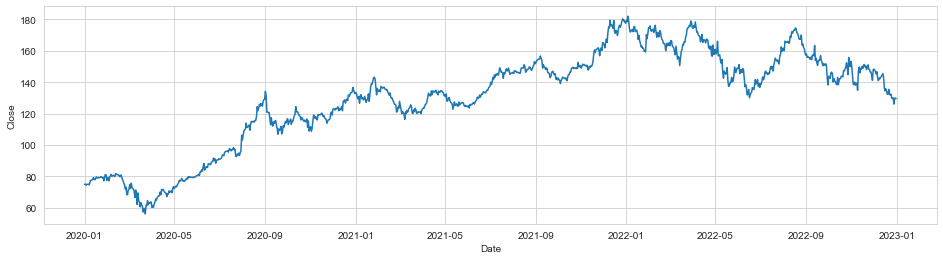

In [14]:
plt.figure(figsize=(16,4))
sns.lineplot(data=df, x='Date', y='Close');

# datanya belum stasioner
# kalau mau digunakan dalam modeling ARIMA, maka harus dilakukan differencing agar stasioner.

## Data Splitting

- splitting tidak boleh random, 
- test set harus dari sekian baris paling akhir

In [15]:
train = df[df['Date']<'2022-10-01']
test = df[df['Date']>='2022-10-01']

## Cek stationarity dengan adfuller test

Hypotheses:
- Ho: Data tidak stasioner
- Ha: Data stasioner

In [16]:
from statsmodels.tsa.stattools import adfuller 

In [17]:
# cek stationarity di dataset asli
pvalue = adfuller(train['Close'])[1]
pvalue

# pvalue > 0.05 --> Fail reject Ho --> Data tidak stasioner
# berarti kita harus lakukan differencing

0.40135738745596305

In [18]:
# dataset setelah 1 kali differencing 
pvalue_diff1 = adfuller(train['Close'].diff().dropna())[1]
pvalue_diff1

# pvalue < 0.05 --> reject Ho --> Data stasioner

7.909242616411295e-26

## ACF-PACF

- Untuk melihat apakah data sudah stasioner atau belum, dicirikan dengan grafik ACF yg slowly decaying
- Untuk menentukan hyperparameter terbaik untuk model ARIMA(p,d,q)

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [20]:
train = train.copy() 

In [21]:
train['Close_diff1'] = train['Close'].diff()
train['Close_diff2'] = train['Close'].diff().diff()

train.head()

,hari_ke,Date,Close,Close_diff1,Close_diff2
0,0,2020-01-01,74.958000,NaN,NaN
1,1,2020-01-02,75.087502,1.295016e-01,NaN
2,2,2020-01-03,74.357498,-7.300040e-01,-0.859506
3,3,2020-01-04,74.958000,6.005024e-01,1.330506
4,4,2020-01-05,74.958000,-1.421085e-14,-0.600502


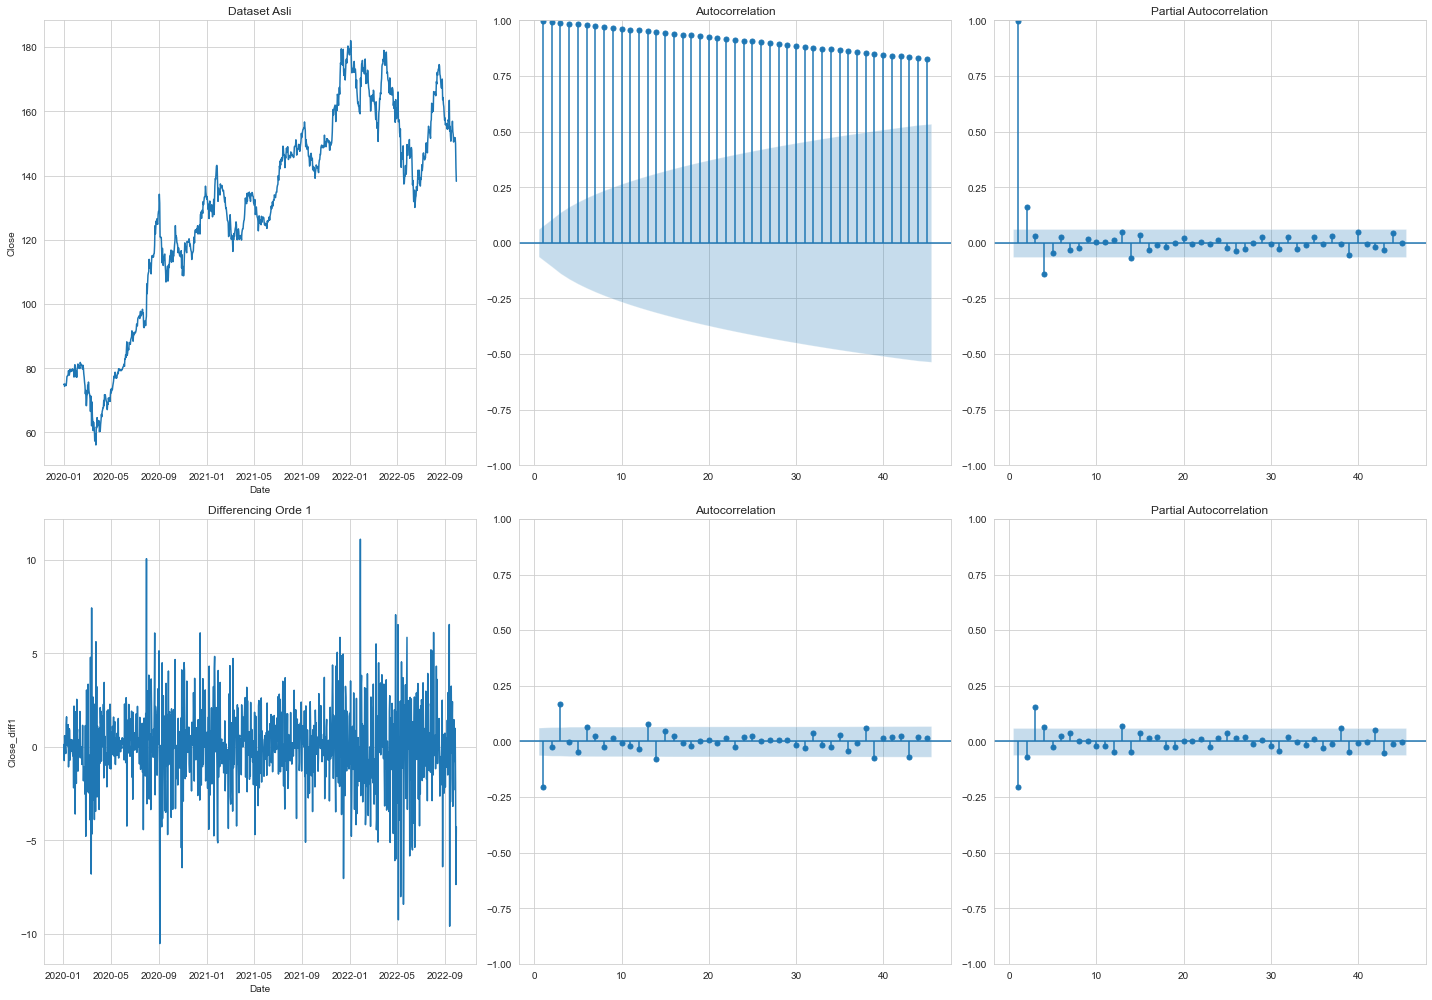

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,14))

# Dataset asli
sns.lineplot(data=train, x='Date', y='Close', ax= axes[0,0])
axes[0,0].set_title('Dataset Asli')
plot_acf(train['Close'], lags= 45, ax= axes[0,1], zero=False)
plot_pacf(train['Close'], lags= 45, ax= axes[0,2], zero=False)

# Differencing Orde 1
sns.lineplot(data=train, x='Date', y='Close_diff1', ax= axes[1,0])
axes[1,0].set_title('Differencing Orde 1')
plot_acf(train['Close_diff1'].dropna(), lags= 45, ax= axes[1,1], zero=False)
plot_pacf(train['Close_diff1'].dropna(), lags= 45, ax= axes[1,2], zero=False)

plt.tight_layout();

Summary: 
- Dataset asli belum stasioner, ditunukkan oleh lineplot dan grafik ACF yg masih slowly decaying
- Pada differencing orde 1 data sudah stasioner
    - AR: PACF cut off
    - I: 1 (Differencing orde 1)
    - MA: ACF cot off
- Jadi bisa kita menggunakan 
    - ARIMA(1,1,0)
    - ARIMA(0,1,1)
    - ARIMA(1,1,1)


## Modeling

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
# define model 
arima = ARIMA(train['Close'], order=(39,1,38))

# fit
arima_fit = arima.fit()

# summary
print(arima_fit.summary())

c:\Users\Abi\miniconda3\envs\pwdenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1004
Model:               ARIMA(39, 1, 38)   Log Likelihood               -2157.741
Date:                Wed, 07 Jun 2023   AIC                           4471.481
Time:                        11:24:29   BIC                           4854.520
Sample:                             0   HQIC                          4617.042
                               - 1004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5529      2.947     -0.188      0.851      -6.329       5.223
ar.L2         -0.2821      4.181     -0.067      0.946      -8.476       7.912
ar.L3          0.1299      4.273      0.030      0.9

In [25]:
# AIC score (semakin kecil nilai AIC, semakin bagus modelnya)
arima_fit.aic

4471.481432532172

## Forecast

Memprediksi Close 6 bulan kedepan

In [26]:
len(test)

92

In [27]:
# prediksi berapa bulan ke depan
forecast_length = len(test)

# forecast (predict)
forecast_result = arima_fit.forecast(forecast_length)
forecast_result

1004    139.934464
1005    138.516498
1006    138.490278
1007    139.367908
1008    138.332701
           ...    
1091    135.482124
1092    134.691707
1093    134.362946
1094    134.391757
1095    134.629544
Name: predicted_mean, Length: 92, dtype: float64

In [28]:
from sklearn.metrics import mean_absolute_error

In [29]:
# MAE
mean_absolute_error(y_true=test['Close'], y_pred=forecast_result)

8.196345280427357

In [30]:
df['forecast_Close'] = forecast_result
df.tail(10)

,hari_ke,Date,Close,forecast_Close
1086,1086,2022-12-22,132.229996,136.525549
1087,1087,2022-12-23,131.860001,136.706570
1088,1088,2022-12-24,132.373999,136.546339
1089,1089,2022-12-25,129.954000,136.690886
1090,1090,2022-12-26,129.493999,135.719029
1091,1091,2022-12-27,130.029999,135.482124
1092,1092,2022-12-28,126.040001,134.691707
1093,1093,2022-12-29,129.610001,134.362946
1094,1094,2022-12-30,129.929993,134.391757
1095,1095,2022-12-31,129.493999,134.629544


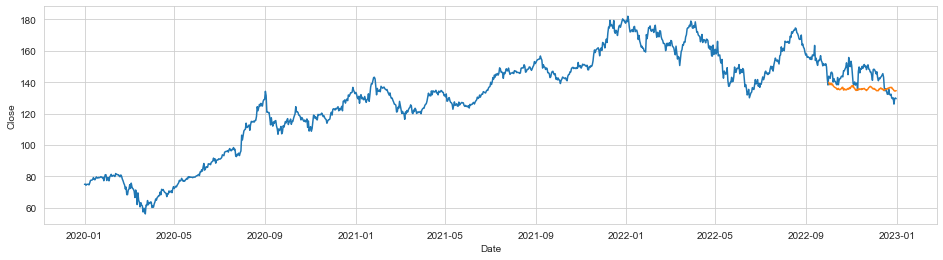

In [31]:
plt.figure(figsize=(16,4))
sns.lineplot(data=df, x='Date', y='Close')
sns.lineplot(data=df, x='Date', y='forecast_Close');

## Tuning pakai pmdarima

In [32]:
# pip install pmdarima

In [33]:
from pmdarima import auto_arima

In [34]:
# auto_arima(
#     train['Close'],
#     trace=True,
#     # start_p= 2,
#     # max_p= 10
# )

## Tuning manual

In [35]:
# list_mae = []
# list_pdq = []

# for p in range(2,50,2):
#     for d in range(0,1):
#         for q in range(2,50,2):

#             # define model 
#             arima = ARIMA(train['Close'], order=(p,d,q))
#             arima_fit = arima.fit()

#             # prediksi berapa bulan ke depan
#             forecast_length = len(test)
#             forecast = arima_fit.forecast(forecast_length)
            
#             mae = mean_absolute_error(y_true=test['Close'], y_pred=forecast)
#             list_mae.append(mae)
#             list_pdq.append([p,d,q])

In [36]:
# df_mae = pd.DataFrame()
# df_mae['pdq'] = list_pdq
# df_mae['MAE'] = list_mae

# df_mae = df_mae.sort_values('MAE')
# df_mae.head()

In [37]:
# best_p = df_mae['pdq'][0][0]
# best_d = df_mae['pdq'][0][1]
# best_q = df_mae['pdq'][0][2]


In [38]:
best_p = 3
best_d = 0
best_q = 2


In [39]:
# best

# define model 
arima_best = ARIMA(train['Close'], order=(best_p, best_d, best_q))

# fit
arima_best_fit = arima_best.fit()

# prediksi berapa bulan ke depan
forecast_length = len(test)

# forecast (predict)
forecast_best = arima_best_fit.forecast(forecast_length)
 
mean_absolute_error(y_true=test['Close'], y_pred=forecast_best)

6.982147720314748

''

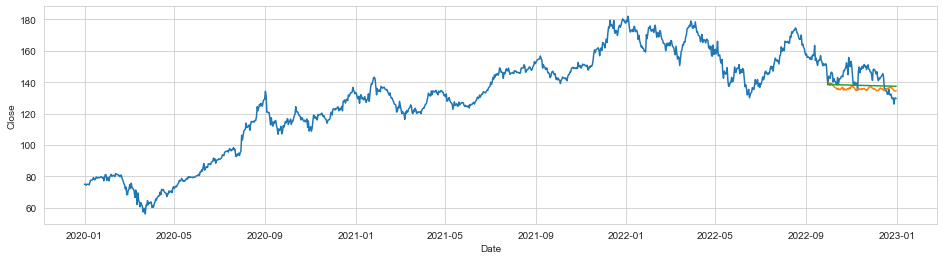

In [40]:
plt.figure(figsize=(16,4))
sns.lineplot(data=df, x='Date', y='Close')
sns.lineplot(data=df, x='Date', y='forecast_Close') # orange
sns.lineplot(data=df, x='Date', y=forecast_best)     # hijau

;